In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bezier

In [2]:
""""TO DO: 
- Make an implementation for noise in the data - GP 
   - if taking GP approach, implement jax compatible scipy.special.comb 
"""

'"TO DO: \n- Make an implementation for noise in the data - GP \n   - if taking GP approach, implement jax compatible scipy.special.comb \n'

## Read and set up example airfoil

In [4]:
"""read files"""
x_data_raw = pd.read_csv('./data/XFOIL_BNN_train.csv',header=None)
Cp_data_raw = pd.read_csv('./data/XFOIL_BNN_values.csv',header=None)
airfoils_raw = pd.read_csv('./data/XFOIL_BNN_ref.csv',header=None) # Name values
airfoilName = np.array(airfoils_raw.values.reshape((-1,1)))

"""select specfic airfoil"""
afIndex = 212
x = x_data_raw.values.T[afIndex, :300]
y = x_data_raw.values.T[afIndex, 300:600]
cp = Cp_data_raw.values.T[afIndex, :]
airfoil = airfoilName[afIndex]

"""plot selected airfoil"""
f, ax = plt.subplots(1,2, figsize=(12, 5))
# plot coordiantes
ax[0].plot(x, y, 'k-')
ax[0].title.set_text(airfoil[0] + ' profile')
ax[0].set_xlabel('x/c')
ax[0].set_ylabel('y/c')
ax[0].axis('equal')
# plot pressure distribution
ax[1].plot(x, cp)
ax[1].title.set_text(airfoil[0] + ' pressure distribution')
ax[1].set_xlabel('x/c')
ax[1].set_ylabel('$C_p$')
ax[1].invert_yaxis()
plt.close()

## Application - airfoil profile

Example of doing Bezier fit on airfoil profile

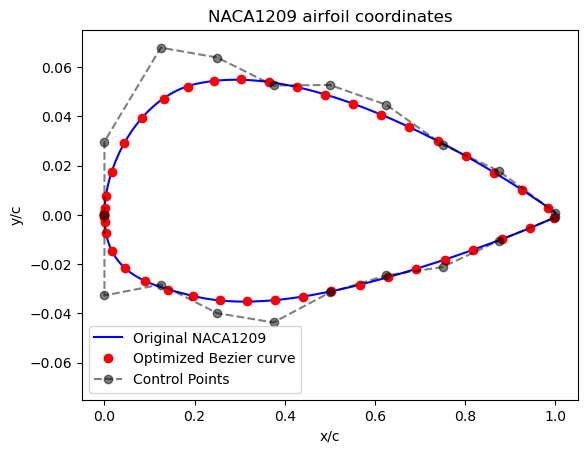

In [11]:
zeroLoc = np.argwhere(np.diff(x)<= 0.0)[-1][0]
x_u = x[:zeroLoc+1].flatten()
x_l = x[zeroLoc+1:].flatten()
y_u = y[:zeroLoc+1].flatten()
y_l = y[zeroLoc+1:].flatten()

X1 = np.flip(x_u)
Y1 = np.flip(y_u)
X2 = x_l
Y2 = y_l 

from scipy.optimize import  least_squares

num_opt_pt = 8
fit_upper = bezier.Bezier(X1, Y1, np.ones(num_opt_pt)*np.max(Y1), 'airfoil') # initialize
res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt)*np.max(Y1))
fit_lower = bezier.Bezier(X2, Y2, np.ones(num_opt_pt)*np.max(Y2), 'airfoil') # initialize
res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt)*np.max(Y2))

plt.figure()
plt.plot(x, y, 'b-', label='Original ' + airfoil[0])
plt.plot(fit_upper.curve[0][::7], fit_upper.curve[1][::7],'ro', label = 'Optimized Bezier curve')
plt.plot(fit_upper.ctrl_pts[:,0], fit_upper.ctrl_pts[:,1], 'ko--', alpha = 0.5, label = 'Control Points')
plt.plot(fit_lower.curve[0][::7], fit_lower.curve[1][::7],'ro')
plt.plot(fit_lower.ctrl_pts[:,0], fit_lower.ctrl_pts[:,1], 'ko--', alpha = 0.5)
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.ylim([-0.075, 0.075])
plt.title(airfoil[0] + " airfoil coordinates")
plt.legend()


Trend study

Text(0.5, 1.0, 'Number of points vs. RMSE')

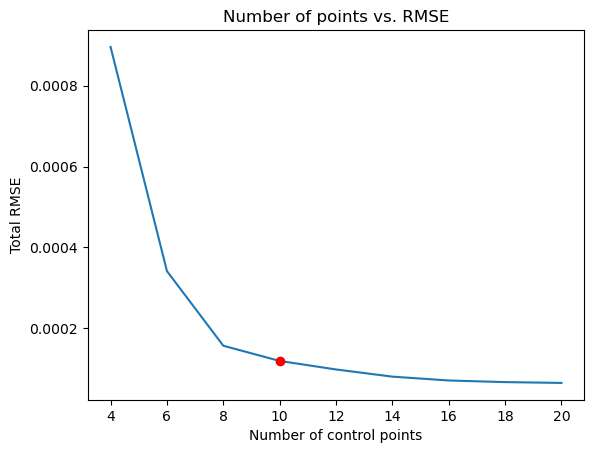

In [21]:
runNew1 = False
if runNew1:
    rmse = []
    degree_range = np.arange(2, 20, 2)
    for i in degree_range:
        num_opt_pt = i
        fit_upper = bezier.Bezier(X1, Y1, np.ones(num_opt_pt)*np.max(Y1)) # initialize
        res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt)*np.max(Y1))
        fit_lower = bezier.Bezier(X2, Y2, np.ones(num_opt_pt)*np.max(Y2)) # initialize
        res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt)*np.max(Y2))
        rmse.append((fit_upper.loss + fit_lower.loss)/2)

plt.plot(degree_range+2, rmse)
plt.plot(8+2, rmse[3],'ro')
plt.xlabel('Number of control points')
plt.ylabel('Total RMSE')
plt.title('Number of points vs. RMSE')

## Application - pressure coefficients

Example of doing Bezier fit on pressure coefficients 

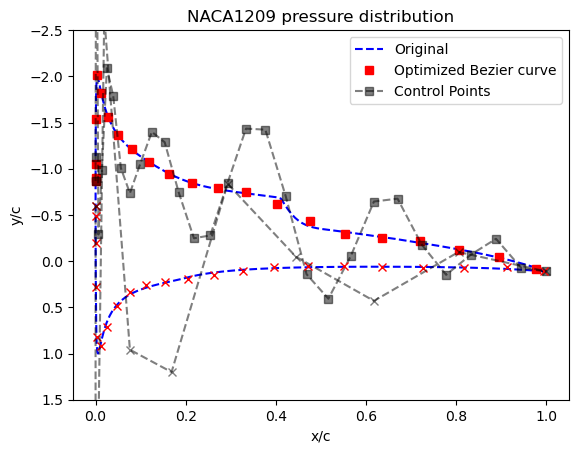

In [26]:
runNew2 = False
if runNew2:
    zeroLoc = np.argwhere(np.diff(x)<= 0.0)[-1][0]
    x_u = x[:zeroLoc+1].flatten()
    x_l = x[zeroLoc+1:].flatten()
    cp_u = cp[:zeroLoc+1].flatten()
    cp_l = cp[zeroLoc+1:].flatten()

    X1 = np.flip(x_u)
    Y1 = np.flip(cp_u)
    X2 = x_l
    Y2 = cp_l 

    num_opt_pt_u = 28
    num_opt_pt_l = 8
    fit_upper = bezier.Bezier(X1, Y1, np.ones(num_opt_pt_u)*-1, 'pressure') # initialize
    res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt_u)*-1)
    fit_lower = bezier.Bezier(X2, Y2, np.ones(num_opt_pt_l), 'pressure') # initialize
    res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt_l))

plt.figure() 
plt.plot(x, cp, 'b--', label='Original')
plt.plot(fit_upper.curve[0][::7], fit_upper.curve[1][::7],'rs', label = 'Optimized Bezier curve')
plt.plot(fit_upper.ctrl_pts[:,0], fit_upper.ctrl_pts[:,1], 'ks--', alpha = 0.5, label = 'Control Points')
plt.plot(fit_lower.curve[0][::7], fit_lower.curve[1][::7],'rx')
plt.plot(fit_lower.ctrl_pts[:,0], fit_lower.ctrl_pts[:,1], 'kx--', alpha = 0.5)
plt.xlabel('x/c')
plt.ylabel('y/c')
plt.title(airfoil[0] + " pressure distribution")
plt.legend()
plt.ylim([-2.5,1.5])
plt.gca().invert_yaxis()

Trend study

Text(0.5, 1.0, 'Number of points vs. RMSE')

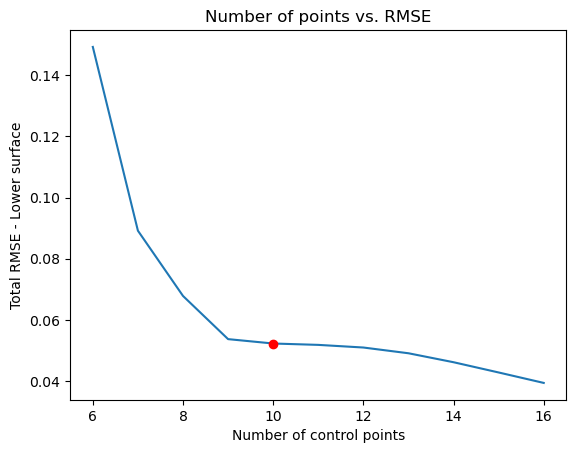

In [33]:
"""Lower surface trend study"""
runNew3 = False
if runNew3:
    rmse = []
    degree_range = np.arange(4, 15, 1)
    for i in degree_range:
        num_opt_pt = i
        fit_lower = bezier.Bezier(X2, Y2, np.ones(num_opt_pt), 'pressure') # initialize
        res_lower = least_squares(fit_lower.update, np.ones(num_opt_pt))
        rmse.append(fit_lower.loss)

plt.figure()
plt.plot(degree_range+2, rmse)
plt.plot(8+2, rmse[4],'ro')
plt.xlabel('Number of control points')
plt.ylabel('Total RMSE - Lower surface')
plt.title('Number of points vs. RMSE')

Text(0, 0.5, 'Total RMSE - Upper surface')

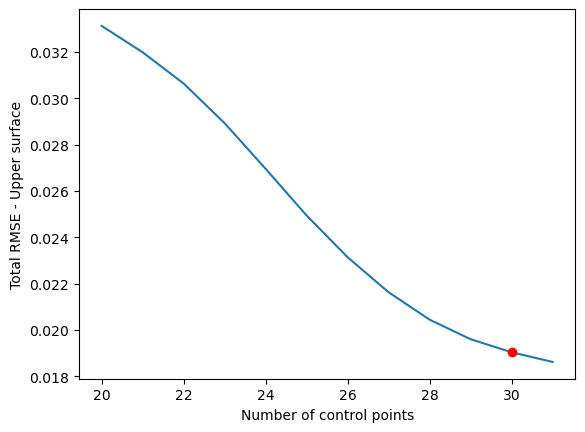

In [37]:
"""Upper surface trend study"""
degree_range = np.arange(18, 30, 1)
runNew4 = False
if runNew4:
    rmse = []
    for i in degree_range:
        num_opt_pt = i
        fit_upper = bezier.Bezier(X1, Y1, np.ones(num_opt_pt)*-1, 'pressure') # initialize
        res_upper = least_squares(fit_upper.update, np.ones(num_opt_pt)*-1)
        rmse.append(fit_upper.loss)

plt.figure()
plt.plot(degree_range+2, rmse)
plt.plot(28+2, rmse[10],'ro')
plt.xlabel('Number of control points')
plt.ylabel('Total RMSE - Upper surface')